In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
PACKAGE_ROOT = os.path.dirname(os.path.abspath(""))
# print(PACKAGE_ROOT)
sys.path.insert(0, PACKAGE_ROOT)

import numpy as np
import pandas as pd
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Dropout
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical
from preprocessing.lstm_softmax_preprocessor import LSTMSoftmaxPreprocessor
from commons import constants as C
from utils.utils import get_connl_data
from utils.utils import SentenceGetter
from preprocessing.lstm_softmax_preprocessor import LSTMSoftmaxPreprocessor
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Dropout

In [2]:
train_df = get_connl_data("train")
valid_df = get_connl_data("valid")
test_df = get_connl_data("test")

train_sentences = SentenceGetter(train_df).sentences
valid_sentences = SentenceGetter(valid_df).sentences

In [3]:
from preprocessing.lstm_crf_preprocessor import LSTMCRFPreprocessor
obj = LSTMCRFPreprocessor()
train_sentences = obj.get_sentences(train_df)

words = obj.get_words(train_df)
n_words = len(words)
print(f"Number of words: {n_words}")
tags = obj.get_tags(train_df)
n_tags = len(tags)
print(f"Number of tags: {n_tags}")
max_length = obj.get_max_length(train_sentences)
print(f"Maximum length of sentence: {max_length}")

Number of words: 34142
Number of tags: 68
Maximum length of sentence: 68


In [4]:
word2idx, idx2word, tag2idx, idx2tag = obj.get_indices(words, tags)
X_train, y_train = obj.preprocess(
    train_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)
y_train = np.array(y_train)
X_valid, y_valid = obj.preprocess(
    valid_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)
y_valid = np.array(y_valid)

In [5]:
# input = Input(shape=(max_len,))
# model = Embedding(input_dim=n_words + 1, output_dim=20,
#                   input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
# model = Bidirectional(LSTM(units=50, return_sequences=True,
#                            recurrent_dropout=0.1))(model)  # variational biLSTM
# model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
# crf = CRF(n_tags)  # CRF layer
# out = crf(model)  # output

# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [6]:
from tf2crf import CRF, ModelWithCRFLoss
input = Input(shape=(max_length,), dtype=np.int32)
model = Embedding(input_dim=n_words, output_dim=20,
                  input_length=max_length, mask_zero=True)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(units=n_tags)
output = crf(model)
base_model = Model(input, output)
model = ModelWithCRFLoss(base_model, sparse_target=True)
model.compile(optimizer="adam", loss=crf.accuracy_fn)
# model.build(input_shape=(max_length,))
# model.summary()
# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
history = model.fit(x=X_train, y=y_train, epochs=1, batch_size=256, validation_split=0.3, verbose=3) # type: ignore

Loss


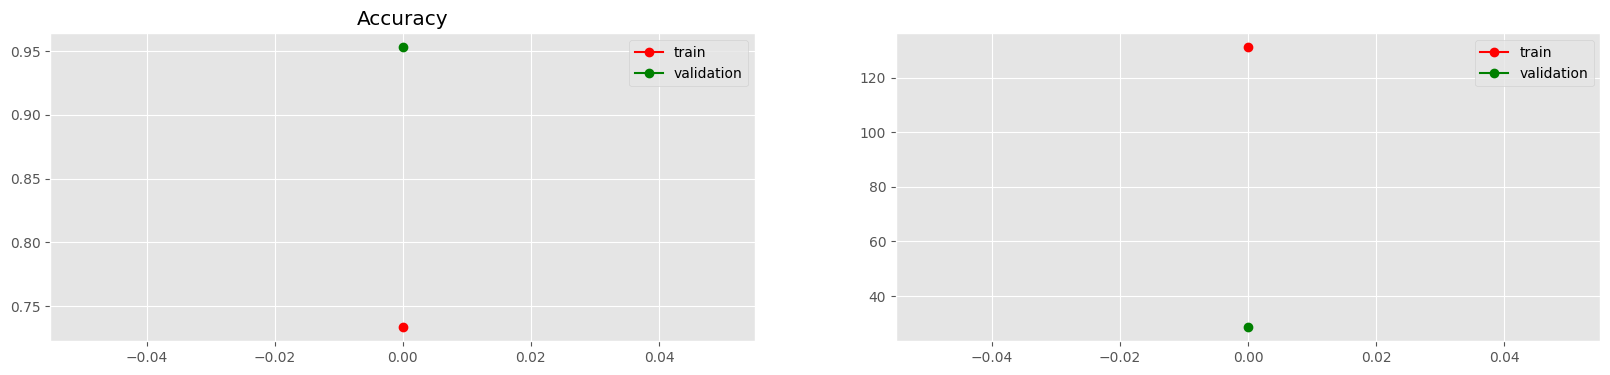

In [9]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(hist["accuracy"], label="train", marker="o", c="red")
plt.plot(hist["val_val_accuracy"], label="validation", marker="o", c="green")
plt.legend()
# plt.show()
plt.subplot(1, 2, 2)
print("Loss")
plt.plot(hist["loss"], label="train", marker="o", c="red")
plt.plot(hist["val_loss_val"], label="validation", marker="o", c="green")
plt.legend()
plt.show()

In [10]:
obj.inference(model, X_train, y_train, idx2tag, train_sentences)

524/524 [==============================] - 12s 23ms/step
Shape of y_pred: (16767, 68)


,precision,recall,f1-score,support
B-AerospaceManufacturer,0.000000,0.000000,0.000000,194.0
B-AnatomicalStructure,0.000000,0.000000,0.000000,333.0
B-ArtWork,0.000000,0.000000,0.000000,193.0
B-Artist,0.000000,0.000000,0.000000,2742.0
B-Athlete,0.000000,0.000000,0.000000,1259.0
B-CarManufacturer,0.000000,0.000000,0.000000,215.0
B-Cleric,0.000000,0.000000,0.000000,283.0
B-Clothing,0.000000,0.000000,0.000000,190.0
B-Disease,0.000000,0.000000,0.000000,342.0
B-Drink,0.000000,0.000000,0.000000,197.0


In [11]:
obj.inference(model, X_valid, y_valid, idx2tag, train_sentences)

28/28 [==============================] - 1s 23ms/step
Shape of y_pred: (871, 68)


,precision,recall,f1-score,support
B-AerospaceManufacturer,0.000000,0.000000,0.000000,8.0
B-AnatomicalStructure,0.000000,0.000000,0.000000,10.0
B-ArtWork,0.000000,0.000000,0.000000,8.0
B-Artist,0.000000,0.000000,0.000000,130.0
B-Athlete,0.000000,0.000000,0.000000,53.0
B-CarManufacturer,0.000000,0.000000,0.000000,9.0
B-Cleric,0.000000,0.000000,0.000000,13.0
B-Clothing,0.000000,0.000000,0.000000,7.0
B-Disease,0.000000,0.000000,0.000000,12.0
B-Drink,0.000000,0.000000,0.000000,7.0


In [14]:
model.save('tests/1')

INFO:tensorflow:Assets written to: tests/1\assets


INFO:tensorflow:Assets written to: tests/1\assets
